<a href="https://colab.research.google.com/github/srini229/EE5333_tutorials/blob/master/rt/Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.8/441.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.16.0
    Uninstalling cffi-1.16.0:
      Successfully uninstalled cffi-1.16.0


# RSMT using min-cost flow in a network

* $V$ is the set of input vertices to be connected using a RSMT
* $G\equiv (V',E)$ is the Hanan-grid of $V$
* Choose a source vertex $s \in V$ and other vertices in $V \setminus \{s\}$ become the sinks
* $w_{u,v}$ is the cost of edge $(u, v) \in E$
* $y_{u,v}\in\{0,1\}$ is the indicator variable for $(u, v)$ being in the RSMT
* $f_{u,v}^t\in [0,1]$ is the flow variable for edge $(u, v)$, sink $t$

In [ ]:
import mip
import math
import networkx as nx

def rsmt(points, lpfile="", draw=False):
  assert len(points) > 1, "works only for 2 or more points"
  X = sorted(list(set([p[0] for p in points])))
  Y = sorted(list(set([p[1] for p in points])))

  G = nx.DiGraph()
  for xi in X:
    for yi in Y:
      G.add_node((xi, yi))

  for i in range(len(X)):
    for j in range(len(Y)):
      if i < len(X) - 1 and j < len(Y) - 1:
        G.add_edge((X[i], Y[j]), (X[i + 1], Y[j]), weight = (X[i + 1] - X[i]))
        G.add_edge((X[i], Y[j]), (X[i], Y[j + 1]), weight = (Y[j + 1] - Y[j]))
        G.add_edge((X[i + 1], Y[j]), (X[i], Y[j]), weight = (X[i + 1] - X[i]))
        G.add_edge((X[i], Y[j + 1]), (X[i], Y[j]), weight = (Y[j + 1] - Y[j]))
      elif i < len(X) - 1:
        G.add_edge((X[i], Y[j]), (X[i + 1], Y[j]), weight = (X[i + 1] - X[i]))
        G.add_edge((X[i + 1], Y[j]), (X[i], Y[j]), weight = (X[i + 1] - X[i]))
      elif j < len(Y) - 1:
        G.add_edge((X[i], Y[j]), (X[i], Y[j + 1]), weight = (Y[j + 1] - Y[j]))
        G.add_edge((X[i], Y[j + 1]), (X[i], Y[j]), weight = (Y[j + 1] - Y[j]))

  model = mip.Model(solver_name='CBC')
  src = points[0]
  tgts = set(points[1:])
  xvars = dict()
  yvars = dict()
  for t in tgts:
    for e in G.edges:
      xvars[(e,t)] = model.add_var(name=f"x_e_{e[0][0]}_{e[0][1]}_{e[1][0]}_{e[1][1]}_t_{t[0]}_{t[1]}", lb=0, ub=1)

# in flow at src = 0 and out flow = 1
  for t in tgts:
    model += (mip.xsum(xvars[(e,t)] for e in G.out_edges(src)) == 1.)
    model += (mip.xsum(xvars[(e,t)] for e in G.in_edges(src)) == 0.)

# in flow at sink = 1 and out flow = 0
  for t in tgts:
    model += (mip.xsum(xvars[(e,t)] for e in G.in_edges(t)) == 1.)
    model += (mip.xsum(xvars[(e,t)] for e in G.out_edges(t)) == 0.)

# y_{u,v} for maximal sharing of edges across paths
  yvars_dict = dict()
  for e in G.edges:
    if e[0][0] < e[1][0] or e[0][1] < e[1][1]:
      for t in tgts:
        if not yvars_dict.get(e): yvars_dict[e] = []
        yvars_dict[e].append(t)
  for e, l in yvars_dict.items():
    yvars[e] = model.add_var(var_type=mip.BINARY, name=f"y_e_{e[0][0]}_{e[0][1]}_{e[1][0]}_{e[1][1]}")
    for t in l:
      model += xvars[(e,t)] + xvars[((e[1], e[0]),t)] <= yvars[e]

# flow conservation for each sink
  for tgt in tgts:
    othVertices = set(G.nodes) - set([tgt]) - set([src])
    for v in othVertices:
      model += mip.xsum(xvars[(e, tgt)] for e in G.in_edges(v)) == mip.xsum(xvars[(e,tgt)] for e in G.out_edges(v))

  model.objective = mip.xsum(G.edges[e]['weight'] * yvars[e] for e in yvars)

  model.write(lpfile if lpfile != "" else "out.lp")
  model.verbose = 0

  model.optimize()
  rsmtLen = 0
  stedges = [e for e in yvars if yvars[e].x >= 0.9]
  outv = set()
  for e in stedges:
    outv.add(e[0])
    outv.add(e[1])
    rsmtLen += G.edges[e]['weight']
  print("RSMT len : ", rsmtLen)

  if draw:
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={e:G.edges[e]['weight'] for e in G.edges})
    nx.draw_networkx_edges(G, pos, edgelist = stedges, edge_color="r", style="dashed")
    plt.show()

  return (rsmtLen, stedges)


RSMT len :  20


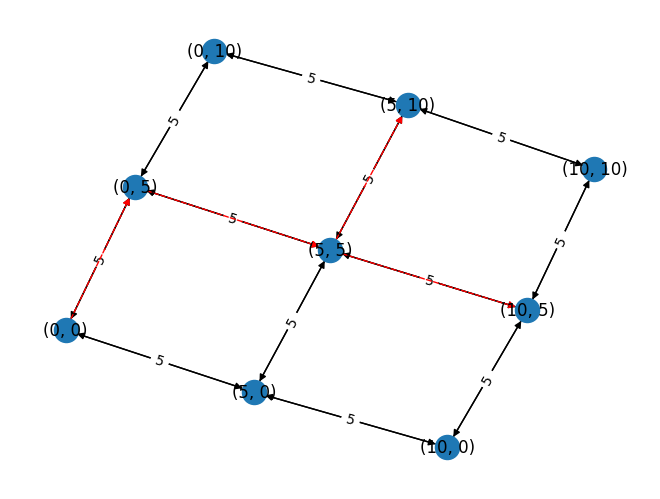

RSMT len :  35


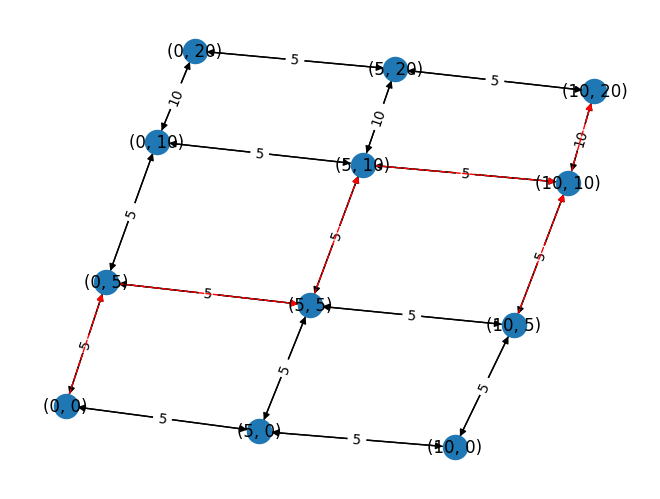

[((0, 0), (0, 5)),
 ((0, 5), (5, 5)),
 ((5, 5), (5, 10)),
 ((5, 10), (10, 10)),
 ((10, 5), (10, 10)),
 ((10, 10), (10, 20))]

In [ ]:
rsmt([(0,0),(10,5),(5,10)], "", True)
rsmt([(0,0),(10,5),(5,10),(10,20)], "", True)

# Minimum Spanning Tree
## Prim’s algorithm from MST
* Input graph $G \equiv (V, E)$ and each edge $(u, v) \in E$ has a cost $w_{u,v} \in \mathbb{R}^+$
  1. Choose s ∈ V and insert it into visited set: $Visited = \{s\}$
  2. $T = \emptyset$
  3. Repeat as long as $|T| < |V| - 1$
    1. $u \in V \setminus Visited$ is the nearest neighbour of $Visited$
    2. $v$ is the the nearest neighbour of $u$ in $Visited$
    3. Insert $(u, v)\in E$ into $T$
  4. Return $T$

In [ ]:
def rmst(points):
  G = nx.Graph()
  for p in points:
    G.add_node(p)
  for i in range(len(points)):
    for j in range(i + 1, len(points)):
      G.add_edge(points[i], points[j], weight = abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1]))
  return None

In [ ]:
rmst([(0,0),(10,5),(5,10)])
rmst([(0,0),(10,5),(5,10),(10,20)])

# Improved 1-Steiner

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/rt/fig/improved_1S.png" width=900 height=448 />

In [ ]:
def improved1s(points):
  return None

In [ ]:
N=5
points = [(random.randint(0,100), random.randint(0,100)) for i in range(N)]
for fn in [rsmt, rmst, improved1s]:
  length, sol = fn(points)
  print(fn.__name__, length)